In [1]:
%matplotlib inline

# Assuming we are in the notebooks directory, we need to move one up:
%cd ../..

/home/seb/Documents/neural_link_SV_iDE


In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns

import matplotlib.pyplot as plt
import statsmodels.api as sm

sns.set(font_scale=1.8)
sns.set_style('ticks')


# files for FSL: gain, loss, risk, entropy, a*gain+b*loss

In [3]:
df = pd.read_csv('./data/participants_and_model.csv')
df['chosen'] = (df['accept'] - 1) + df['accept']
df['chosen*gain'] = df['chosen'] *  df['gain']
df['chosen*loss'] = df['chosen'] *  df['loss']
df['chosen*entropy'] = df['chosen'] *  df['entropy']
df['risk*entropy'] = df['chosen'] *  df['entropy']

decision_time_slack = 0.5 #ms
df['response_onset'] = df['onset'] + df['RT'] - decision_time_slack
df['response_duration'] = (4 + decision_time_slack) - df['RT']

df['subjective_value'] = (df['gain'] *  df['gain_coef']) + (df['loss'] *  df['loss_coef'])
#added model_conflict = ((accept-1)+accept)*(p_accept-0.5)*-1
#using subjective_value instead of mc_subjective_value

df['model_conflict'] = df['model_conflict'] + np.random.normal(0,0.000000001,len(df['model_conflict']))
df['subjective_value'] = df['subjective_value'] + np.random.normal(0,0.000000001,len(df['subjective_value']))

In [16]:
confidence = []
for response in df['participant_response']:
    if response=='weakly_accept':
        confidence.append(0)
    elif response=='weakly_reject':
        confidence.append(0)
    elif response=='strongly_accept':
        confidence.append(1)
    elif response=='strongly_reject':
        confidence.append(1)

df['confidence'] = confidence

In [17]:
df.columns
#df['confidence']

Index(['trial', 'onset', 'duration', 'gain', 'loss', 'RT',
       'participant_response', 'ID', 'run', 'risk', 'use', 'accept',
       'model_conflict', 'group', 'gender', 'age', 'intercept', 'p_accept',
       'entropy', 'mc_loss', 'mc_gain', 'mc_entropy', 'gain_coef', 'loss_coef',
       'intercept_coef', 'loglikelihood', 'subjective_value', 'chosen',
       'chosen*gain', 'chosen*loss', 'chosen*entropy', 'risk*entropy',
       'response_onset', 'response_duration', 'confidence'],
      dtype='object')

In [18]:
split_conflict = 0; split_subval = 0 #default unless splitting
#variables = ['mc_loss', 'mc_gain', 'mc_entropy', 'intercept', 'mc_subjective_value' ]
#variables = ['model_conflict', 'chosen']
#variables = ['model_conflict']; split_conflict = -1 #need to run w/ +1 & -1 (high & low)
variables = ['subjective_value']; split_subval = -1

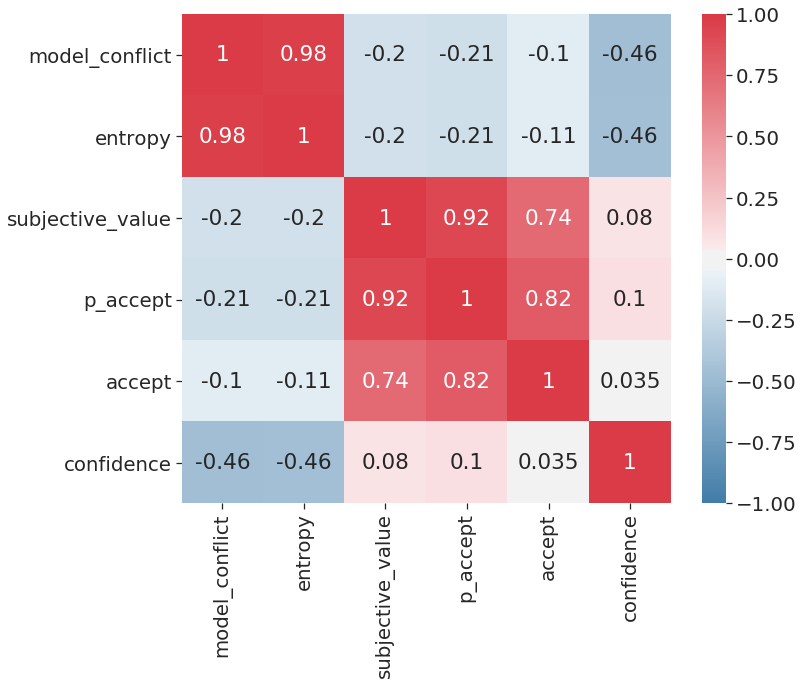

In [21]:
#corr = df[['mc_loss', 'mc_gain', 'mc_entropy', 'chosen',
#   'chosen*gain', 'chosen*loss', 'chosen*entropy']].corr()

corr = df[['model_conflict','entropy','subjective_value','p_accept','accept','confidence']].corr(method='spearman')
# # Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, annot = True, 
            center=0,square=True, vmin=-corr.max().max(), vmax=corr.max().max())
plt.show()

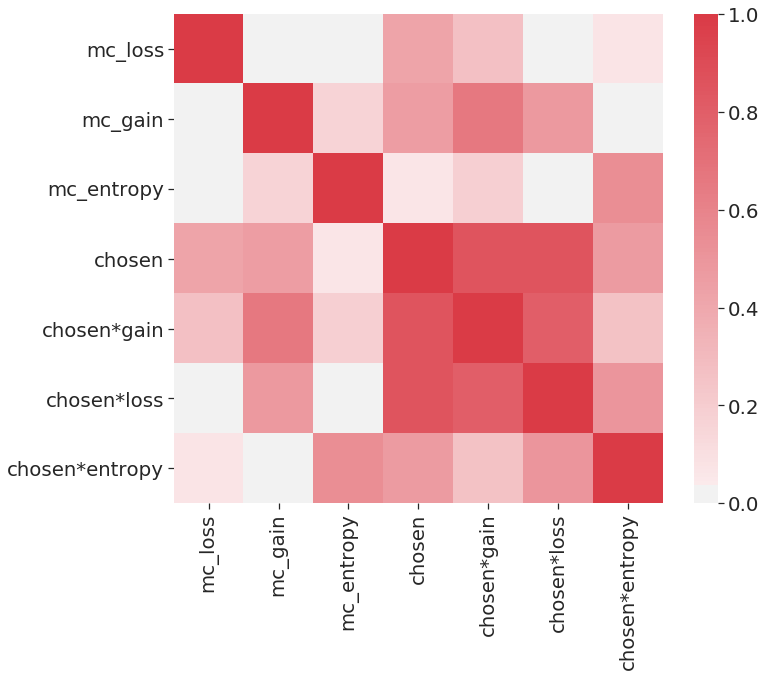

In [9]:
corr = df[['mc_loss', 'mc_gain', 'mc_entropy', 'chosen',
   'chosen*gain', 'chosen*loss', 'chosen*entropy']].corr()
corr = np.fabs(corr)
# # Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, center=0,square=True, vmin=0, vmax=corr.max().max())
plt.show()

In [10]:
corr

mc_loss   mc_gain  mc_entropy    chosen  chosen*gain  \
mc_loss         1.000000  0.001954    0.000180  0.427078     0.267247   
mc_gain         0.001954  1.000000    0.168801  0.453672     0.660217   
mc_entropy      0.000180  0.168801    1.000000  0.064177     0.190867   
chosen          0.427078  0.453672    0.064177  1.000000     0.851831   
chosen*gain     0.267247  0.660217    0.190867  0.851831     1.000000   
chosen*loss     0.011736  0.476791    0.038981  0.858321     0.802781   
chosen*entropy  0.072077  0.010582    0.543853  0.474175     0.258735   

                chosen*loss  chosen*entropy  
mc_loss            0.011736        0.072077  
mc_gain            0.476791        0.010582  
mc_entropy         0.038981        0.543853  
chosen             0.858321        0.474175  
chosen*gain        0.802781        0.258735  
chosen*loss        1.000000        0.503920  
chosen*entropy     0.503920        1.000000

In [8]:
# get each person's ID
IDs = df['ID'].unique()
print(IDs)

[  1   2   3   4   5   6   8   9  10  11  13  14  15  16  17  18  19  20
  21  22  24  25  26  27  29  30  32  33  35  36  37  38  39  40  41  43
  44  45  46  47  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  66  67  68  69  70  71  72  73  74  75  76  77  79  80  81  82
  83  84  85  87  88  89  90  92  93  94  95  96  98  99 100 102 103 104
 105 106 107 108 109 110 112 113 114 115 116 117 118 119 120 121 123 124]


In [19]:
# For each participant...
for ID in IDs:
    print(ID)
    p_df = df[df['ID'] == ID]
    if split_conflict!=0 or split_subval!=0:
        tmp_median = p_df[variables[0]].median()
        print(tmp_median)
        #continue
    runs = p_df['run'].unique()
    assert (runs == [1, 2, 3, 4]).all()
    for run in runs:
        #print(ID, run)
        r_df = p_df[p_df['run'] == run]
        if split_conflict==1:
            r_df = r_df[r_df['model_conflict'] > tmp_median].copy()
            str_variable = 'model_conflict_high'
        elif split_conflict==-1:
            r_df = r_df[r_df['model_conflict'] <= tmp_median].copy()
            str_variable = 'model_conflict_low'
        if split_subval==1:
            r_df = r_df[r_df['subjective_value'] > tmp_median].copy()
            str_variable = 'subval_pos'
        elif split_subval==-1:
            r_df = r_df[r_df['subjective_value'] <= tmp_median].copy()
            str_variable = 'subval_neg'
        for variable in variables:
            if split_conflict!=0 or split_subval!=0:
                path = './data/behavior/' + str_variable + '/'
                filepath = (path + str(ID) + '_' + str(run) +
                       '_' + str_variable + '.txt')
            else:
                path = './data/behavior/' + variable + '/'
                filepath = (path + str(ID) + '_' + str(run) +
                       '_' + variable + '.txt')
            #columns = ['onset', 'duration', variable]
            columns = ['response_onset', 'response_duration', variable]
            # onset, duration, VARIABLE, one file per run
            try:
                os.mkdir(path)
            except FileExistsError:
                None
            r_df.iloc[0:len(r_df)-1].to_csv(filepath, sep=' ', index=False, 
                                            header=False, columns=columns)
            r_df.iloc[[len(r_df)-1]].to_csv(filepath,
                                            sep=' ', index=False,
                                            header=False, columns=columns,
                                            mode='a', line_terminator="")



1
21.21745941086204
2
2.701674607118213
3
6.705618988771448
4
0.6858947989271269
5
-1.465086371682748
6
-3.0399492855892327
8
-2.7208355623425424
9
10.601424863394472
10
0.0034456827348329742
11
9.87194806097959
13
884.087657241177
14
-1.120665877497456e-09
15
1.7037823976277666
16
-0.274692073155976
17
3.3758390668493554
18
0.06470862896654797
19
11.98018338195998
20
0.0965960908629172
21
2.827127411203467
22
-3.4469235514779983
24
-3.7867761596437672
25
241.22234685122282
26
0.054164471707426394
27
-2.6226963207267486
29
5.174377056611748
30
1.5205796297983643
32
-1.337753675259691
33
7.716731406493436
35
2.1201467069134914
36
1.774103889773785
37
1.092515332784734
38
0.8427334255301456
39
-0.19150099271782922
40
-0.9795693922147748
41
5.199523377494607
43
12.260590808154287
44
0.8198346841450734
45
-1.5353884574186398
46
-0.40515500188897224
47
5.363365072101965
49
1.1866199839064253
50
0.7419170853260039
51
-0.19671888188930034
52
-1.2565057998442761
53
4.152235064683072
54
0.39176

In [14]:
variable
#r_df

'mc_subjective_value'

In [12]:
r_df.columns

Index(['trial', 'onset', 'duration', 'gain', 'loss', 'RT',
       'participant_response', 'ID', 'run', 'risk', 'use', 'accept', 'group',
       'gender', 'age', 'intercept', 'p_accept', 'entropy', 'mc_loss',
       'mc_gain', 'mc_entropy', 'gain_coef', 'loss_coef', 'intercept_coef',
       'loglikelihood', 'chosen', 'chosen*gain', 'chosen*loss',
       'chosen*entropy', 'risk*entropy'],
      dtype='object')

In [13]:
r_df

trial    onset  duration  gain  loss     RT participant_response   ID  \
27390      1    4.048         4    10     6  1.339        weakly_accept  124   
27391      2   13.132         4    13    18  1.338      strongly_reject  124   
27392      3   18.333         4    11    18  1.031      strongly_reject  124   
27393      4   24.434         4    10    11  1.031        weakly_reject  124   
27394      5   32.135         4    17     6  1.956      strongly_accept  124   
27395      6   40.330         4    15    13  1.443        weakly_reject  124   
27396      7   49.430         4     9    10  1.134        weakly_reject  124   
27397      8   56.330         4    20    10  1.341      strongly_accept  124   
27398      9   64.331         4    17     5  1.340      strongly_accept  124   
27399     10   69.931         4    15    19  1.236      strongly_reject  124   
27400     11   75.831         4    20     5  1.237      strongly_accept  124   
27401     12   82.531         4    15    17  2.061        weakly_reject  124   
27402     13   91.531         4    12     7  1.752        weakly_accept  124   
27403     14   99.031         4     6    11  1.134      strongly_reject  124   
27404     15  105.935         4    14     8  1.752        weakly_accept  124   
27405     16  114.333         4     9    13  1.649      strongly_reject  124   
27406     17  120.534         4    19    19  1.340        weakly_reject  124   
27407     18  128.136         4     6     6  1.031        weakly_reject  124   
27408     19  134.332         4    18    15  1.854        weakly_accept  124   
27409     20  140.933         4    18    11  1.546        weakly_accept  124   
27410     21  150.632         4     7     8  1.235        weakly_reject  124   
27411     22  158.432         4    14    16  1.134        weakly_reject  124   
27412     23  167.332         4    11     7  1.236        weakly_accept  124   
27413     24  173.333         4    18     9  2.371      strongly_accept  124   
27414     25  179.132         4    16    12  1.544        weakly_accept  124   
27415     26  187.232         4    19    20  1.235        weakly_reject  124   
27416     27  192.833         4     7     6  1.443        weakly_reject  124   
27417     28  197.932         4    17    14  1.545        weakly_accept  124   
27418     29  203.433         4    18    10  1.340        weakly_accept  124   
27419     30  208.833         4    16     9  1.649        weakly_accept  124   
...      ...      ...       ...   ...   ...    ...                  ...  ...   
27424     35  246.134         4    10    10  1.134        weakly_reject  124   
27425     36  252.734         4    11    10  1.546        weakly_reject  124   
27426     37  262.033         4     8    12  1.133      strongly_reject  124   
27427     38  267.734         4    18    14  1.135        weakly_accept  124   
27428     39  275.334         4    10    17  1.133      strongly_reject  124   
27429     40  280.334         4     8     6  1.752        weakly_accept  124   
27430     41  288.134         4     7    10  0.927      strongly_reject  124   
27431     42  293.634         4    16    15  1.237        weakly_reject  124   
27432     43  298.634         4     8    19  1.031      strongly_reject  124   
27433     44  303.734         4    10    15  1.135      strongly_reject  124   
27434     45  309.334         4    12    14  2.163      strongly_reject  124   
27435     46  319.236         4     6    18  0.926      strongly_reject  124   
27436     47  328.137         4    20    14  1.647        weakly_accept  124   
27437     48  334.235         4    13     7  2.265        weakly_accept  124   
27438     49  340.435         4     7    19  1.030      strongly_reject  124   
27439     50  347.435         4    10    20  1.030      strongly_reject  124   
27440     51  353.535         4    19     7  1.647      strongly_accept  124   
27441     52  358.735         4    16    20  1.855      strongly_reject  124   
27442  

In [8]:
df_y = df[df['accept'] == 1]

In [9]:
df_n = df[df['accept'] == 0]

In [10]:
df_n.columns = [s + '_n' for s in df_n.columns]
df_y.columns = [s + '_y' for s in df_y.columns]

In [11]:
del df

In [12]:
suffixes = ['_n', '_y']

In [13]:
dfs = [df_n, df_y]

In [14]:
df_y

trial_y  onset_y  duration_y  gain_y  loss_y   RT_y  \
0            1    4.071           4      14       6  2.388   
1            2   11.834           4      34      14  2.289   
2            3   19.535           4      34      13  1.873   
5            6   43.935           4      20       8  1.767   
6            7   50.535           4      28       9  1.561   
...        ...      ...         ...     ...     ...    ...   
27437       48  334.235           4      13       7  2.265   
27440       51  353.535           4      19       7  1.647   
27444       55  378.335           4      16      11  1.133   
27446       57  391.235           4      16       8  1.339   
27447       58  400.536           4      15       8  1.443   

      participant_response_y  ID_y  run_y     risk_y  ...  gain_coef_y  \
0              weakly_accept     1      1   7.615773  ...     1.600386   
1            strongly_accept     1      1  18.384776  ...     1.600386   
2            strongly_accept     1      1  18.200275  ...     1.600386   
5              weakly_accept     1      1  10.770330  ...     1.600386   
6            strongly_accept     1      1  14.705441  ...     1.600386   
...                      ...   ...    ...        ...  ...          ...   
27437          weakly_accept   124      4   7.382412  ...     5.344673   
27440        strongly_accept   124      4  10.124228  ...     5.344673   
27444          weakly_accept   124      4   9.708244  ...     5.344673   
27446        strongly_accept   124      4   8.944272  ...     5.344673   
27447          weakly_accept   124      4   8.500000  ...     5.344673   

       loss_coef_y  intercept_coef_y loglikelihood_y subjective_value_y  \
0        -1.499745         -1.928603        -12.5280          13.406937   
1        -1.499745         -1.928603        -12.5280          33.416702   
2        -1.499745         -1.928603        -12.5280          34.916447   
5        -1.499745         -1.928603        -12.5280          20.009765   
6        -1.499745         -1.928603        -12.5280          31.313110   
...            ...               ...             ...                ...   
27437    -5.781355         -7.755088         -8.0898          29.011257   
27440    -5.781355         -7.755088         -8.0898          61.079293   
27444    -5.781355         -7.755088         -8.0898          21.919854   
27446    -5.781355         -7.755088         -8.0898          39.263920   
27447    -5.781355         -7.755088         -8.0898          33.919247   

       chosen_y  chosen*gain_y  chosen*loss_y  chosen*entropy_y  \
0             1             14              6      1.863586e-04   
1             1             34             14      9.887468e-13   
2             1             34             13      2.287188e-13   
5             1             20              8      3.865721e-07   
6             1             28              9      7.592057e-12   
...         ...            ...            ...               ...   
27437         1             13              7      1.884465e-08   
27440         1             19              7      0.000000e+00   
27444         1             16             11      1.542873e-05   
27446         1             16              8      9.685650e-13   
27447         1             15              8      1.699121e-10   

       risk*entropy_y  
0        1.863586e-04  
1        9.887468e-13  
2        2.287188e-13  
5        3.865721e-07  
6        7.592057e-12  
...               ...  
27437    1.884465e-08  
27440    0.000000e+00  
27444    1.542873e-05  
27446    9.685650e-13  
27447    1.699121e-10  

[15201 rows x 32 columns]

In [15]:
for df, suffix in zip(dfs, suffixes):
    p_df = df[df['ID' + suffix] == ID]
    # For each participant...
    for ID in IDs:
        runs = p_df['run' + suffix].unique()
        assert (runs == [1, 2, 3, 4]).all()
        for run in runs:
            r_df = p_df[p_df['run' + suffix] == run]
            for variable in variables:
                variable  += suffix
                columns = ['onset' + suffix, 'duration' + suffix, variable]
                directory = './data/behavior/' + variable + '/'
                path =  directory + str(ID) + '_' + str(run) + '_' + variable + '.txt'
                try:
                    os.mkdir(directory)
                except FileExistsError:
                    None
                # onset, duration, VARIABLE, one file per run
                r_df.iloc[0:len(r_df)-1].to_csv('./data/behavior/' + variable + '/' + str(ID) + '_' + str(run) + '_' + variable + '.txt',
                            sep=' ', index=False, header=False, columns=columns)
                r_df.iloc[[len(r_df)-1]].to_csv(path,
                            sep=' ', index=False, header=False, columns=columns,
                                                mode='a',line_terminator="")


In [22]:
# check how correlated risk and p are here

In [23]:
# include coef[0]*gain + coef[1]*loss as a column 

In [24]:
# include all coefs are columns too

In [25]:
df.columns


Index(['trial_y', 'onset_y', 'duration_y', 'gain_y', 'loss_y', 'RT_y',
       'participant_response_y', 'ID_y', 'run_y', 'risk_y', 'use_y',
       'accept_y', 'group_y', 'gender_y', 'age_y', 'intercept_y', 'p_accept_y',
       'entropy_y', 'mc_loss_y', 'mc_gain_y', 'mc_entropy_y', 'gain_coef_y',
       'loss_coef_y', 'intercept_coef_y', 'loglikelihood_y', 'chosen_y',
       'chosen*gain_y', 'chosen*loss_y', 'chosen*entropy_y', 'risk*entropy_y'],
      dtype='object')

In [26]:

sns.pairplot(df[variables])

KeyError: "None of [Index(['mc_loss', 'mc_gain', 'mc_entropy', 'intercept', 'mc_subjective_value'], dtype='object')] are in the [columns]"